# **Libraries & Functions**

In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Time
import time
import datetime

%matplotlib inline

# fix random seed for reproducibility
seed = 3541
np.random.seed(seed)

In [ ]:
!pip install tqdm


In [ ]:
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:
        return 'Date today: %s' % datetime.date.today()

In [ ]:
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

In [ ]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text


In [ ]:
from tqdm import tqdm

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    norm_docs.append(doc)

  return norm_docs

# **Load Data**

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nadahamdi","key":"b72247aa1851f1d5f6367035f41b8432"}'}

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d bittlingmayer/amazonreviews

Dataset URL: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews
License(s): unknown
 99% 489M/493M [00:08<00:00, 55.5MB/s]
100% 493M/493M [00:08<00:00, 62.7MB/s]


In [ ]:
!unzip amazonreviews.zip

Archive:  amazonreviews.zip
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        


In [ ]:
import bz2

output_path='/train.ft.txt'
with bz2.open('/content/train.ft.txt.bz2','rt',encoding='utf-8') as compressed_file,open(output_path,'w',encoding='utf-8') as output_file:
    for line in compressed_file :
        output_file.write(line)
    print('Train Successful')

output_path='/test.ft.txt'
with bz2.open('/content/test.ft.txt.bz2','rt',encoding='utf-8') as compressed_file,open(output_path,'w',encoding='utf-8') as output_file:
    for line in compressed_file :
        output_file.write(line)
    print('Test Successful')

Train Successful
Test Successful


In [ ]:
from tqdm import tqdm
train,test,train_labels,test_labels=[],[],[],[]
with open ('/train.ft.txt','r',encoding='utf-8') as file :
    lines=file.readlines()
for line in tqdm(lines):
    train.append(line.split('__label__')[1][1:])
    train_labels.append(line.split('__label__')[1][0])
with open ('/test.ft.txt','r',encoding='utf-8') as file :
    lines=file.readlines()
for line in tqdm(lines):
    test.append(line.split('__label__')[1][1:])
    test_labels.append(line.split('__label__')[1][0])

100%|██████████| 400000/400000 [00:00<00:00, 424680.08it/s]


In [ ]:
import pandas as pd
train_data = {
  "review": train,
  "label": train_labels,
}
test_data = {
  "review": test,
  "label": test_labels,
}
test_data = pd.DataFrame(test_data)
train_data = pd.DataFrame(train_data)

In [ ]:
test_data=test_data.head(200)

In [ ]:
train_data.drop_duplicates(subset='review',inplace=True)
test_data.drop_duplicates(subset='review',inplace=True)

In [ ]:
train_data = train_data.sample(frac=1)
test_data = test_data.sample(frac=1)

In [ ]:
# Remove rows with empty reviews
train_data = train_data.dropna(subset=['review'])

# Alternatively, if the review column contains whitespace strings but not NaN values
train_data = train_data[train_data['review'].str.strip() != '']

# Reset index after removing rows
train_data = train_data.reset_index(drop=True)

In [ ]:
# Remove rows with empty reviews
test_data = test_data.dropna(subset=['review'])

# Alternatively, if the review column contains whitespace strings but not NaN values
test_data = test_data[test_data['review'].str.strip() != '']

# Reset index after removing rows
test_data = test_data.reset_index(drop=True)

In [ ]:
from sklearn.model_selection import train_test_split
# Splitting the data using stratified sampling
X_train, X_val, y_train, y_val = train_test_split(
    train_data['review'],  # Features
    train_data['label'],                   # Labels
    test_size=0.2,                   # Percentage of data to use as validation set
    random_state=42,                 # Random seed for reproducibility
    stratify=train_data['label']           # Perform stratified sampling based on the labels
)

X_test = test_data['review']
y_test = test_data['label'].values
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [ ]:
(X_train[1])

' Syndicated episdoes = no $$$ from me: I have tons of blank DVDRs and VHS tapes laying around the house. I can just record syndicated episodes off of cable TV. Why buy them? I wouldn\'t buy a book that is missing pages. Studios often re-release movies with "extra footage" or "director\'s cut" or "extended edition". How many do you think they would sell if they released a shortened version...like a Gone With the Wind that is only 2 hours long. I will no longer buy any DVD set with syndicated episodes. If the message is not sent to the studios right now, then they will ocntinue to take the cheap and easy path.\n'

In [ ]:
X_test.head()

,review
0,Fantastic Product: I purchased this cheese gr...
1,Not as musical as I had hoped: I purchased th...
2,WHY ?? WHY ??: Why would anyone do a movie th...
3,Great for work: I keep this at my desk becaus...
4,If there was an option to give this book NO s...


In [ ]:
X_train_p, _, y_train_p, _ = train_test_split(
    X_train,                    # Features
    y_train,                   # Labels
    train_size=0.005,                  # Percentage of data to use for training
    random_state=42,                 # Random seed for reproducibility
    stratify=y_train           # Perform stratified sampling based on the labels
)
X_val_p, _, y_val_p, _ = train_test_split(
    X_val,  # Features
    y_val,                   # Labels
    train_size=0.005,                  # Percentage of data to use for training
    random_state=42,                 # Random seed for reproducibility
    stratify=y_val           # Perform stratified sampling based on the labels
)
X_test_p, _, y_test_p, _ = train_test_split(
    X_test,  # Features
    y_test,                   # Labels
    train_size=0.005,                  # Percentage of data to use for training
    random_state=42,                 # Random seed for reproducibility
    stratify=y_test           # Perform stratified sampling based on the labels
)



In [ ]:
y_test_p.head()

,0
380743,1
221996,1
346864,2
69502,2
364196,2


In [ ]:
X_test_p.head()

,review
380743,Could be better: This toy was a gift for our ...
221996,Poor service: Initially I was pleased with ho...
346864,The Kids love them!!: These are awesome littl...
69502,"""Judge for yourself , "" Judge for yourself.: ..."
364196,Perfect!: I have had a little Holmes air clea...


In [ ]:
X_test_p = X_test_p['review']
y_test_p = y_test_p[0]

In [ ]:
type(X_train_p)

pandas.core.series.Series

In [ ]:
cnt = pd.Series(y_train_p)
cnt.value_counts()

label
1    7200
2    7200
Name: count, dtype: int64

In [ ]:
cnt = pd.Series(y_val_p)
cnt.value_counts()

label
1    1800
2    1800
Name: count, dtype: int64

In [ ]:
cnt = pd.Series(y_test_p)
cnt.value_counts()

0
1    1000
2    1000
Name: count, dtype: int64

In [ ]:
test_data = test_data.head(1000)

In [ ]:
y_test_p.head()

380743    1
221996    1
346864    2
69502     2
364196    2
Name: 0, dtype: object

# **Preprocessing**

In [ ]:
%%time

X_train = pre_process_corpus(X_train_p)
X_val = pre_process_corpus(X_val_p)
X_test = pre_process_corpus(X_test_p)


  0%|          | 0/14400 [00:00<?, ?it/s]<ipython-input-5-0bd1e2d37541>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 2000/2000 [00:00<00:00, 4462.10it/s]

CPU times: user 4.65 s, sys: 38.1 ms, total: 4.69 s
Wall time: 6.24 s


In [ ]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on train documents
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0

In [ ]:
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
X_val = t.texts_to_sequences(X_val)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=54180
Number of Documents=14400


# **Data Visualization**

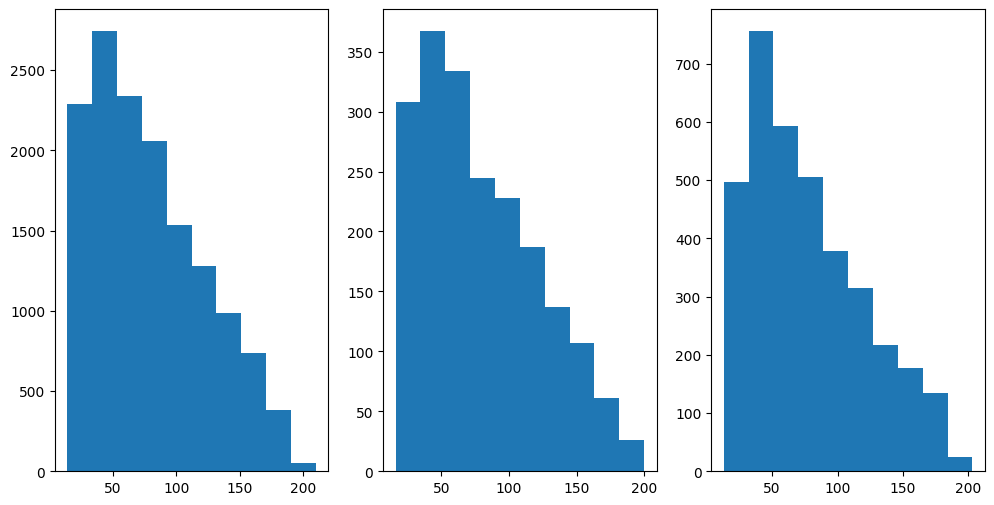

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]
val_lens = [len(s) for s in X_val]


fig, ax = plt.subplots(1,3, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)
h3 = ax[2].hist(val_lens)


# **Sequence Normalization and Encoding Labels**

In [ ]:
MAX_SEQUENCE_LENGTH = 220
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
X_val = sequence.pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.15.0


In [ ]:
le = LabelEncoder()
num_classes=2
y_train = le.fit_transform(y_train_p.ravel())
y_test = le.transform(y_test_p.ravel())
y_val = le.transform(y_val_p.ravel())

In [ ]:
VOCAB_SIZE = len(t.word_index)

# **Model (CNN)**

In [ ]:
from keras.utils import to_categorical


In [ ]:
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
y_train.shape

(14400, 2)

In [ ]:
EMBED_SIZE = 300
Adam = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)


In [ ]:
#create model arch
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate=0.10))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate=0.10))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate=0.10))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=loss, optimizer=Adam, metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 220, 300)          16254000  
                                                                 
 conv1d_15 (Conv1D)          (None, 220, 32)           38432     
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 110, 32)           0         
 ng1D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 110, 32)           0         
                                                                 
 conv1d_16 (Conv1D)          (None, 110, 64)           8256      
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 55, 64)            0         
 ng1D)                                                

In [ ]:
# Fit the model
with tf.device('/GPU:0'):
    history1 = model.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=10, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/10
450/450 [==============================] - 241s 529ms/step - loss: 0.5633 - accuracy: 0.7572 - val_loss: 0.5134 - val_accuracy: 0.8039
Epoch 2/10
450/450 [==============================] - 237s 526ms/step - loss: 0.3992 - accuracy: 0.8915 - val_loss: 0.4583 - val_accuracy: 0.8494
Epoch 3/10
450/450 [==============================] - 237s 527ms/step - loss: 0.3128 - accuracy: 0.9468 - val_loss: 0.4421 - val_accuracy: 0.8475
Epoch 4/10
450/450 [==============================] - 224s 498ms/step - loss: 0.2764 - accuracy: 0.9691 - val_loss: 0.4260 - val_accuracy: 0.8644
Epoch 5/10
450/450 [==============================] - 225s 500ms/step - loss: 0.2452 - accuracy: 0.9840 - val_loss: 0.5029 - val_accuracy: 0.8264
Epoch 6/10
450/450 [==============================] - 236s 524ms/step - loss: 0.2290 - accuracy: 0.9888 - val_loss: 0.4749 - val_accuracy: 0.8403
Epoch 7/10
450/450 [==============================] - 228s 506ms/step - loss: 0.2342 - accuracy: 0.9867 - val_loss: 0.4618 -

# **Visualizing and Evaluating the Results**

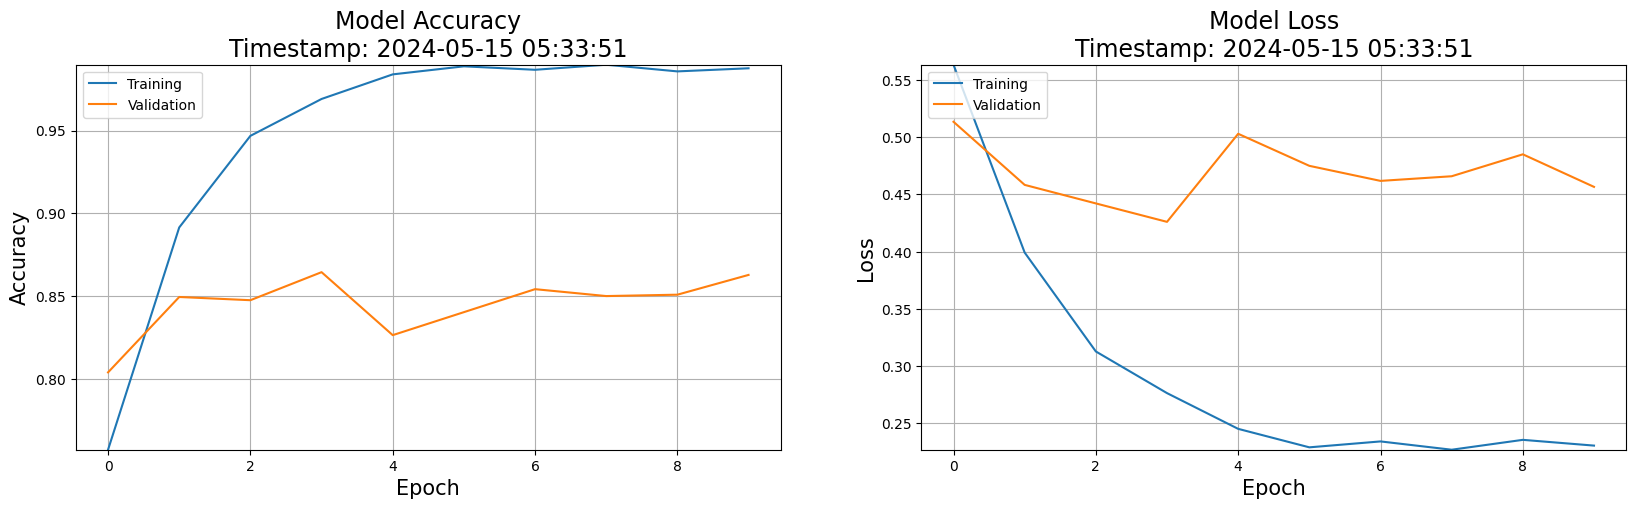

In [ ]:
plot_performance(history=history1)


In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

63/63 [==============================] - 2s 24ms/step - loss: 0.4774 - accuracy: 0.8570
Accuracy: 85.70%


In [ ]:
# prompt: how to get the confusion matrix for this model?

import numpy as np
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
print(confusion_matrix)


63/63 [==============================] - 1s 20ms/step
[[829 171]
 [115 885]]


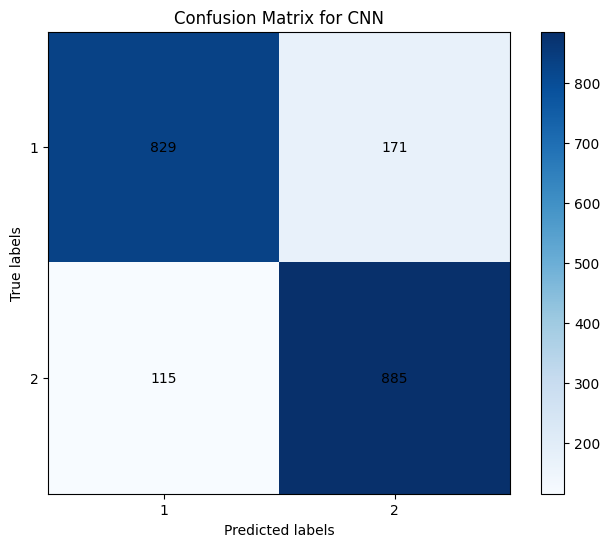

In [ ]:
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix for CNN')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(np.arange(2), [1,2])  # Assuming classes are labeled with their names
plt.yticks(np.arange(2), [1,2])  # Assuming classes are labeled with their names

# Display the value inside the heatmap
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center', color='black')

plt.show()

In [ ]:
# prompt: how to get classification report

print(classification_report(y_true, y_pred, target_names=['1','2']))


              precision    recall  f1-score   support

           1       0.88      0.83      0.85      1000
           2       0.84      0.89      0.86      1000

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



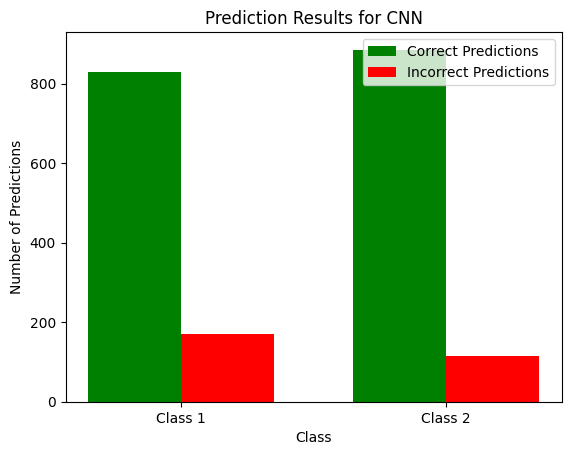

In [ ]:
# prompt: plot the result as bar chart

import matplotlib.pyplot as plt
import numpy as np
# Get the number of correct and incorrect predictions for each class
correct_predictions = confusion_matrix.diagonal()
incorrect_predictions = np.sum(confusion_matrix, axis=1) - correct_predictions

# Create a list of class names
class_names = ['Class 1', 'Class 2']

# Create the bar chart
x_values = np.arange(len(class_names))
bar_width = 0.35
plt.bar(x_values - bar_width/2, correct_predictions, width=bar_width, color='g', label='Correct Predictions')
plt.bar(x_values + bar_width/2, incorrect_predictions, width=bar_width, color='r', label='Incorrect Predictions')

# Add labels and title
plt.xticks(x_values, class_names)
plt.title('Prediction Results for CNN')
plt.xlabel('Class')
plt.ylabel('Number of Predictions')
plt.legend()

# Display the bar chart
plt.show()


In [ ]:
# prompt: how to save this model

model.save('my_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pickle

# Assuming you have a trained model object named 'model'
# For example, let's say 'model' is a trained scikit-learn model
# You would replace 'model' with your actual trained model object

# Save the model to a file
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# prompt: how to predict from model with input example?
'''
import numpy as np
# Load the trained model
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)
'''
# Input example
input_example = ['so good']

# Preprocess the input example
input_example = pre_process_corpus(input_example)
input_example = t.texts_to_sequences(input_example)
input_example = sequence.pad_sequences(input_example, maxlen=MAX_SEQUENCE_LENGTH)

# Make prediction
prediction = model.predict(input_example)

# Get the predicted class label
predicted_class = np.argmax(prediction)

# Print the predicted class label
print(predicted_class)


100%|██████████| 1/1 [00:00<00:00, 1533.01it/s]

1/1 [==============================] - 0s 34ms/step
1


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
example = 'not that good'
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
print (scores)

[0.90654176 0.08211938 0.01133889]


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
# Assuming test_data is your DataFrame containing 'review' and 'label' columns
reviews = test_data['review'].tolist()
labels = test_data['label']
labels = labels.replace({'1': 1, '2': 2})


# Tokenize the text data
tokenized_data = tokenizer(reviews, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    outputs = model(**tokenized_data)
logits = outputs.logits

# Convert logits to probabilities using softmax
probs = torch.softmax(logits, dim=1)

# Extract the model scores (probabilities for each class)
model_scores = probs.cpu().numpy()
print (model_scores)

def map_scores_to_labels(scores):
    predicted_labels = []
    for score in scores:
        if score[1] > score[0]:  # Check if positive score is higher
            predicted_labels.append(2)  # Map to positive label
        else:
            predicted_labels.append(1)  # Map to negative label
    return predicted_labels

# Map model scores to predicted labels
predicted_labels = map_scores_to_labels(model_scores)


[[0.00627987 0.02624005 0.9674801 ]
 [0.04158271 0.10595657 0.8524607 ]
 [0.3272742  0.4164411  0.25628468]
 [0.005544   0.07727948 0.9171765 ]
 [0.06869274 0.24020508 0.6911022 ]
 [0.88339436 0.10552955 0.01107609]
 [0.78344566 0.1717259  0.04482846]
 [0.8376946  0.14760354 0.01470195]
 [0.1293246  0.4410378  0.42963764]
 [0.01594647 0.1557714  0.8282821 ]
 [0.00120495 0.01790967 0.9808853 ]
 [0.42448404 0.4838259  0.09169007]
 [0.93282926 0.05911314 0.00805759]
 [0.00329583 0.01057183 0.9861324 ]
 [0.80620027 0.17270333 0.02109642]
 [0.9355812  0.05662825 0.00779058]
 [0.00732365 0.03079636 0.96187997]
 [0.00139734 0.0103114  0.9882912 ]
 [0.15008734 0.7209168  0.12899587]
 [0.00151152 0.00740271 0.9910857 ]
 [0.9712129  0.02532948 0.00345753]
 [0.9791559  0.01869959 0.00214444]
 [0.00303151 0.03298536 0.9639831 ]
 [0.00143739 0.01969285 0.97886974]
 [0.34465563 0.3515559  0.30378842]
 [0.926275   0.06538271 0.00834224]
 [0.04316132 0.17390715 0.78293157]
 [0.53168344 0.36976472 0.09

'\n# Pass the input data to the model for prediction\nwith torch.no_grad():\n    outputs = model(**tokenized_data)\n\n\nprobs = F.softmax(outputs.logits, dim=1)\n\n# Convert probabilities to predicted labels\npredicted_labels = torch.argmax(probs, dim=1).cpu().numpy()\n\n# # Convert the model predictions to probabilities\n# probs = softmax(outputs.logits, axis=1)\n# predicted_labels = torch.argmax(torch.from_numpy(probs), axis=1).cpu().numpy()\n\n# # Compare the predicted labels to the true labels\n# accuracy = accuracy_score(labels, predicted_labels)\n# print("Accuracy:", accuracy)\n'

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(labels, predicted_labels)
print("Accuracy:", accuracy)

Accuracy: 0.865


In [ ]:
# prompt: how to generate confusion matrix fir this model

from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
confusion_matrix = confusion_matrix(labels, predicted_labels)

# Print the confusion matrix
print(confusion_matrix)


[[ 71  20]
 [  7 102]]


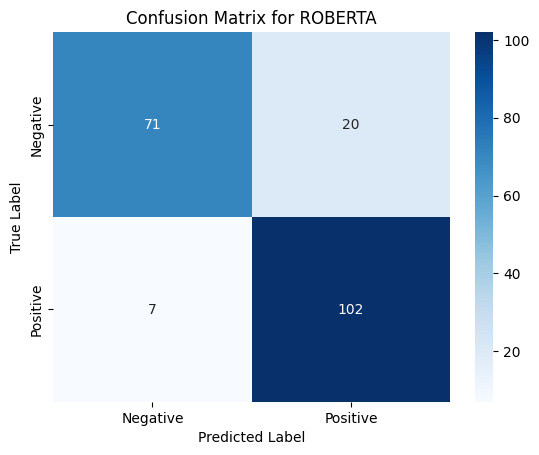

In [ ]:
# prompt: visualize this matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Create the confusion matrix visualization
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix for ROBERTA")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
# prompt: generate classificatio report
from sklearn.metrics import classification_report
# Generate the classification report
classification_report = classification_report(labels, predicted_labels)

# Print the classification report
print(classification_report)


              precision    recall  f1-score   support

           1       0.91      0.78      0.84        91
           2       0.84      0.94      0.88       109

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.86      0.86       200



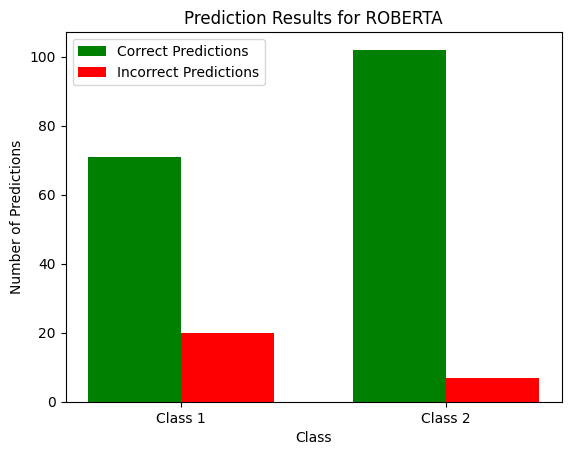

In [ ]:
# prompt: generate bar chart for true and false for each class

import matplotlib.pyplot as plt
import numpy as np
# Get the number of correct and incorrect predictions for each class
correct_predictions = confusion_matrix.diagonal()
incorrect_predictions = np.sum(confusion_matrix, axis=1) - correct_predictions

# Create a list of class names
class_names = ['Class 1', 'Class 2']

# Create the bar chart
x_values = np.arange(len(class_names))
bar_width = 0.35
plt.bar(x_values - bar_width/2, correct_predictions, width=bar_width, color='g', label='Correct Predictions')
plt.bar(x_values + bar_width/2, incorrect_predictions, width=bar_width, color='r', label='Incorrect Predictions')

# Add labels and title
plt.xticks(x_values, class_names)
plt.title('Prediction Results for ROBERTA')
plt.xlabel('Class')
plt.ylabel('Number of Predictions')
plt.legend()

# Display the bar chart
plt.show()
